# Datamining the Protein Data Bank with mmtf-pyspark

mmtf-pyspark is a framework for the interactive mining of the Protein Data Bank (PDB). As an example, this demo analyzes the environment around zinc ions in proteins.

This example demonstrates how to:
    
* Configure pyspark
* Read PDB structures in MMTF file format
* Create a non-redundant subset of structures
* Show results in pandas dataframe
* Plot histogram
* Visualize structures in 3D

For more example notebooks see the [demos folder](./demos) and the
[mmtf-workshop2018](https://github.com/sbl-sdsc/mmtf-workshop-2018)

In [1]:
from pyspark.sql import SparkSession                   
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.interactions import InteractionExtractor, InteractionFilter
from mmtfPyspark.webfilters import Pisces                        
from mmtfPyspark.structureViewer import view_group_interaction
import pandas as pd

## Configure Spark
Setup pyspark to run locally on 4 cores.

In [2]:
spark = SparkSession.builder.master("local[4]").appName("Demo").getOrCreate()
# Enable Arrow-based columnar data transfers to Pandas
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## Read PDB structures
Read a provided sample (~10,000 structures) of the PDB in MMTF format (https://mmtf.rcsb.org).

In [3]:
path = "./resources/mmtf_full_sample/"
pdb = mmtfReader.read_sequence_file(path)

## Create a non-redundant subset
Create a Pisces (Protein Sequence Culling Server, http://dunbrack.fccc.edu/PISCES.php) non-redundant subset for this analysis. Select protein chains with less than 20% sequence identity among each other and a resolution of 2.0 A or better.

In [4]:
pdb = pdb.filter(Pisces(sequenceIdentity = 20, resolution = 2.0))  

## Extract Zinc interactions
Find polar interactions within 3 A around each zinc

In [5]:
interaction_filter = InteractionFilter()
interaction_filter.set_target_elements(False, ['C','H','P'])  # exclude non-polar elements
interaction_filter.set_query_elements(True, ['Zn'])
interaction_filter.set_distance_cutoff(3.0)

interactions = InteractionExtractor().get_ligand_polymer_interactions(pdb, interaction_filter)

## Show table of interactions
Convert Spark dataframe to a Pandas dataframe

In [6]:
df = interactions.toPandas()
df

,structureChainId,queryLigandId,queryLigandChainId,queryLigandNumber,targetGroupId,targetChainId,targetGroupNumber,sequenceIndex,sequence
0,1LFW.A,ZN,A,1002,ASP,A,177,176,MDLNFKELAEAKKDAILKDLEELIAIDSSEDLENATEEYPVGKGPV...
1,1LFW.A,ZN,A,1001,HIS,A,439,438,MDLNFKELAEAKKDAILKDLEELIAIDSSEDLENATEEYPVGKGPV...
2,1LFW.A,ZN,A,1001,ASP,A,119,118,MDLNFKELAEAKKDAILKDLEELIAIDSSEDLENATEEYPVGKGPV...
3,1LFW.A,ZN,A,1001,GLU,A,154,153,MDLNFKELAEAKKDAILKDLEELIAIDSSEDLENATEEYPVGKGPV...
4,1LFW.A,ZN,A,1002,HIS,A,87,86,MDLNFKELAEAKKDAILKDLEELIAIDSSEDLENATEEYPVGKGPV...
5,1LFW.A,ZN,A,1002,ASP,A,119,118,MDLNFKELAEAKKDAILKDLEELIAIDSSEDLENATEEYPVGKGPV...
6,1LU0.A,ZN,A,201,GLU,A,19,18,RVCPRILLECKKDSDCLAECVCLEHGYCG
7,1LU0.B,ZN,A,201,GLU,B,19,18,RVCPRILLECKKDSDCLAECVCLEHGYCG
8,5WLJ.C,ZN,C,103,HIS,C,15,15,XIEELLRKILEDEARHVAELEDIEKWLX
9,5WLJ.A,ZN,A,104,HIS,A,15,15,XIEELLRKILEDEARHVAELEDIEKWLX


## Print histogram of the top 10 interacting amino acid groups

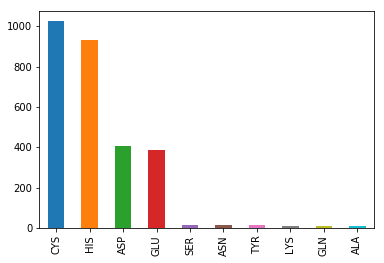

In [7]:
df.targetGroupId.value_counts().head(10).plot(kind='bar');

## Visualize Structures

Create a list of unique PDB ids

In [8]:
df['pdbId'] = df.structureChainId.str[:4]
pdb_ids = list(df.pdbId.drop_duplicates())

Browse through the list by moving the slider.

In [9]:
view_group_interaction(pdb_ids, 'ZN', style = 'cartoon');

interactive(children=(IntSlider(value=0, continuous_update=False, description='Structure', max=384), Output())…

## Stop spark
Always run the notebook to the end to stop spark!

In [10]:
spark.stop()